## YAMnet classification by segmentation | initial dataset training and testing

In [58]:
%load_ext autoreload
%autoreload 2
TRAIN=True

import tensorflow as tf
from tensorflow  import keras
import tensorflow_hub as hub
import numpy as np

import librosa 
from dataset import WavDataset
from config import *
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from config import INTERMEDIATE, MODEL_DIR
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data
- all 5 second overlapping chunks have been pregenerated under ../output/intermediate/train.hdf5 (untracked on github).
- YAMnet produces a 1024-long feature vector per 0.96s windows with a 0.48s hop. Thusly 10 frames are predicted per chunk
- labels encoded as binary frame-wise time steps (4 signal classes)

In [28]:
hdf5_dataset = h5py.File(INTERMEDIATE / 'embeddings.hdf5', 'r')
recordings = np.array(hdf5_dataset)

rec =  recordings[0]

annotated = [
    rec for rec in recordings if np.array(hdf5_dataset[rec]['Y']).sum() > 0
]
len(annotated), hdf5_dataset[rec]['X'].shape

(101, (1249, 1024))

In [29]:
def get_embedding_frames(rec):
    return [
        (rec, i) for i in range(hdf5_dataset[rec]['X'].shape[0])
    ]

embeddings_frames = []
for rec in recordings:
    embeddings_frames.extend(get_embedding_frames(rec))

len(embeddings_frames)

442080

In [33]:
X_shape = (1024,)
Y_shape = (4,)

def embedding_frame_generator(frames):
    for (rec, frame_idx) in frames:
        group =  hdf5_dataset[rec]
        yield (
            np.array(group['X'][frame_idx, :]), 
            np.array(group['Y'][frame_idx, :])
        ) 

raw_dataset = tf.data.Dataset.from_generator( 
    lambda: embedding_frame_generator(embeddings_frames), 
    output_signature=(
        tf.TensorSpec(shape=X_shape, dtype=tf.float32),
        tf.TensorSpec(shape=Y_shape, dtype=tf.bool)))

# test
for s in raw_dataset.take(32):
    X, Y = s    
    print(np.array(X).sum(), np.array(Y).sum(), end="\t\t")

print(X.shape, Y.shape)

57.00635 0		58.285202 0		59.04304 0		56.71453 0		57.66487 0		50.090828 0		53.10558 0		63.703053 0		69.35723 0		67.904816 0		64.400475 0		58.83925 0		53.16173 0		59.326614 0		60.24948 0		57.349216 0		58.80186 0		53.310894 0		61.443405 0		52.015244 0		48.812256 0		66.87404 0		65.887695 0		59.561172 0		65.36894 0		68.77638 0		65.38515 0		52.331062 0		58.556824 0		58.854324 0		63.58287 0		62.07183 0		(1024,) (4,)


In [77]:
n_frames = len(embeddings_frames) 

# shuffle
np.random.seed(0)
np.random.shuffle(embeddings_frames) # TODO add order to model dir

# split chunks test/train/valid
test_cut = int(n_frames * 0.8)
valid_cut = int(test_cut * 0.8) 

train_valid_frames, test_frames = embeddings_frames[:test_cut], embeddings_frames[test_cut:]
train_frames, valid_frames = train_valid[:valid_cut], train_valid[valid_cut:]

spec = (tf.TensorSpec(shape=X_shape, dtype=tf.float32),
        tf.TensorSpec(shape=Y_shape, dtype=tf.bool))

train_dataset = tf.data.Dataset.from_generator(lambda: embedding_frame_generator(train_frames), output_signature=spec)
valid_dataset = tf.data.Dataset.from_generator(lambda: embedding_frame_generator(valid_frames), output_signature=spec)
test_dataset = tf.data.Dataset.from_generator(lambda: embedding_frame_generator(test_frames), output_signature=spec)

print(
    len(train_frames), len(valid_frames), len(test_frames)
)

# test
for s in test_dataset.take(32):
    X, Y = s    
    print(np.array(X).sum(), np.array(Y).sum(), end="\t\t")

print(X.shape, Y.shape)

282931 70733 88416
47.46982 0		53.185875 0		53.694084 0		54.35461 0		51.834087 0		60.01572 0		46.567924 0		61.76877 0		98.84599 0		79.48472 0		85.8453 0		43.72586 0		47.87015 0		97.03653 0		73.54175 0		50.740356 0		60.05765 0		96.00952 0		52.659637 0		62.099316 0		68.575325 0		126.85418 0		84.37164 0		58.926617 0		71.92452 0		83.143555 0		62.76075 0		62.389023 0		63.2009 0		46.753567 0		51.671715 0		84.06982 0		(1024,) (4,)


## Training
Using a simple DNN against the embeddings (** check??)

In [79]:
from keras.layers import Input, Dense, BatchNormalization
# import tensorflow_addons as tfa
from functools import partial
from keras import metrics

def create_model(output_bias=None) -> keras.Model:
    # default_dense =  partial(Dense, activation='selu', # self normalizing
    #                          kernel_initializer=keras.initializers.LecunNormal(seed=0)
    #                         ) # kernel_regularizer ?
    default_dense =  partial(Dense, activation='relu', 
                             kernel_initializer=keras.initializers.LecunNormal(seed=0)
                            ) # kernel_regularizer ?
    
    # simple head for YAMnet base
    return keras.Sequential([
            Input(shape=(1024,)),
            default_dense(512), 
            Dense(4, activation='sigmoid', 
                  bias_initializer=output_bias) # correct this 
    ])

def compile(model):
    thresh = np.arange(10) * 0.1
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',  
        metrics=[
            metrics.Recall(thresholds=0.5),
            metrics.Precision(thresholds=0.5),
            metrics.AUC(curve='pr'),
        ]
    )

model = create_model()
compile(model)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 512)               524800    
                                                                 
 dense_31 (Dense)            (None, 4)                 2052      
                                                                 
Total params: 526,852
Trainable params: 526,852
Non-trainable params: 0
_________________________________________________________________


In [82]:
# 133921 chunks
# 4185 batches

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pandas as pd

class IncrementallySavedCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, **kwargs):
        super().__init__()
        self.checkpoint_dir = checkpoint_dir
    
    def on_epoch_end(self, epoch, logs=None):
        checkpoint_path = Path(self.checkpoint_dir) / f'model_epoch_{epoch+1}.ckpt'
        self.model.save_weights(checkpoint_path)
        print(f"Saved checkpoint for epoch {epoch+1} at {checkpoint_path}")


def train(model, model_dir, stopping_patience=5, 
          stopping_moniter='val_loss', **kwargs):
    
    model_dir.mkdir(exist_ok=True)

    # save frame order
    np.save(model_dir / 'train_frames.npy', train_frames)
    np.save(model_dir / 'valid_frames.npy', valid_frames)
    np.save(model_dir / 'test_frames.npy', test_frames) 

    # tensorboard
    log_dir = model_dir / "logs" / "fit"
    log_dir.mkdir(parents=True, exist_ok=True)
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    # checkpoints
    checkpoint_path = model_dir / "training"
    Path(checkpoint_path).mkdir(exist_ok=True)  
    
    cp_callback = IncrementallySavedCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1  
    )

    # early stopping
    es_checkpoint = EarlyStopping(
        monitor=stopping_moniter,
        patience=stopping_patience,
        restore_best_weights=True,
    )
    
    # fit
    history = model.fit(
        verbose=2,
        callbacks=[tensorboard_callback, cp_callback, es_checkpoint],
        **kwargs
    )
    df = pd.DataFrame(history.history)
    df.to_csv("logs/history.csv")
    model.save(model_dir / 'model.keras')
    return history

    
if TRAIN:
    batch = 64 # try 128 / 256
    epochs = 20
    history = train(
        x=train_dataset.batch(batch).prefetch(tf.data.AUTOTUNE), 
        validation_data=valid_dataset.batch(batch).prefetch(tf.data.AUTOTUNE),
        model=model, 
        model_dir=MODEL_DIR / "20e_embedding_frames", 
        epochs=epochs, 
    )
    
    

Epoch 1/20
Saved checkpoint for epoch 1 at /home/ethan/working/acoustic-AL/models/20e_embedding_frames/training/model_epoch_1.ckpt
4421/4421 - 497s - loss: 0.0084 - recall_12: 0.1317 - precision_10: 0.7125 - auc_17: 0.2539 - val_loss: 0.0078 - val_recall_12: 0.1707 - val_precision_10: 0.7302 - val_auc_17: 0.2912 - 497s/epoch - 113ms/step
Epoch 2/20
Saved checkpoint for epoch 2 at /home/ethan/working/acoustic-AL/models/20e_embedding_frames/training/model_epoch_2.ckpt
4421/4421 - 488s - loss: 0.0076 - recall_12: 0.1779 - precision_10: 0.7264 - auc_17: 0.3188 - val_loss: 0.0075 - val_recall_12: 0.1763 - val_precision_10: 0.7143 - val_auc_17: 0.3207 - 488s/epoch - 110ms/step
Epoch 3/20
Saved checkpoint for epoch 3 at /home/ethan/working/acoustic-AL/models/20e_embedding_frames/training/model_epoch_3.ckpt
4421/4421 - 567s - loss: 0.0072 - recall_12: 0.2172 - precision_10: 0.7437 - auc_17: 0.3612 - val_loss: 0.0073 - val_recall_12: 0.1985 - val_precision_10: 0.7589 - val_auc_17: 0.3481 - 567s

NameError: name 'model_dir' is not defined

In [ ]:
## Evaluation

In [83]:
%load_ext tensorboard
%tensorboard --logdir=/home/ethan/working/acoustic-AL/models/20e_embedding_frames/logs

In [ ]:
# get model from last checkpoint (should be ~E18 -> overfit)
# model = create_model()
# load_status = model.load_weights("/home/ethan/working/acoustic-AL/models/50e_initial_ds/training/model.ckpt")
# load_status.expect_partial() 
# compile(model)

In [84]:
from tqdm import tqdm

def get_predictions(model, batched_test_dataset):
    y_true, y_pred = [], []
    for batch_X, batch_y in tqdm(batched_test_dataset, desc='loading/predicting test ds'):
        predictions = model(batch_X, training=False)
        y_true.extend(batch_y.numpy())
        y_pred.extend(predictions.numpy()) 

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_dataset.batch(32).prefetch(tf.data.AUTOTUNE))
y_true_flat = y_true.reshape(-1, 4)
y_pred_flat = y_pred.reshape(-1, 4)

loading/predicting test ds: 2763it [03:44, 12.30it/s]


In [85]:
# unbalanced classes
labels = [ "fast_trill_6khz", "nr_syllable_3khz", "triangle_3khz", "upsweep_500hz"]
for i, label in enumerate(labels):
    print(f'average class probability of [{label}]: {y_true_flat[:, i].mean()}')

average class probability of [fast_trill_6khz]: 0.0024656170828809263
average class probability of [nr_syllable_3khz]: 0.0029067137169743033
average class probability of [triangle_3khz]: 0.0007690915671371698
average class probability of [upsweep_500hz]: 0.0011423271806007963


In [90]:
# compare predicted labels
annotated = [(y, yp) for (y, yp) in zip(y_true, y_pred) if y.any()] 
for chunks in annotated[:5]:
    annotated_chunk, annotated_chunk_pred = chunks
    if annotated_chunk.any():
        print(annotated_chunk) 
        print(annotated_chunk_pred)


[ True False False False]
[0.00129846 0.00011159 0.00103945 0.0018858 ]
[False False False  True]
[0.00592357 0.00052753 0.00016913 0.00547817]
[False  True False False]
[1.8385649e-03 5.8804435e-01 5.6813650e-07 3.7625159e-05]
[False False False  True]
[2.9501021e-03 3.5363436e-04 7.9011203e-05 2.2474438e-02]
[False  True False False]
[0.00108451 0.00990373 0.01133612 0.00455785]


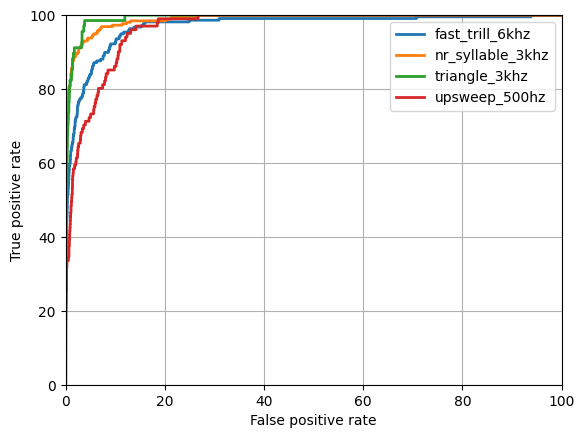

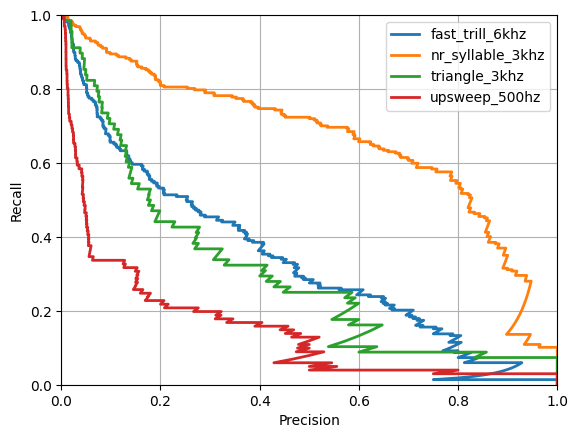

In [91]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.grid(True)

def plot_pr(name, labels, predictions, **kwargs):
    prec, rec, _ = precision_recall_curve(labels, predictions)
    plt.plot(prec, rec, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)

for i, label in enumerate(labels):
    plot_roc(labels, y_true_flat[:, i], y_pred_flat[:, i])
plt.legend(labels) 
plt.show() 

for i, label in enumerate(labels):
    plot_pr(labels, y_true_flat[:, i], y_pred_flat[:, i])
plt.legend(labels) 
plt.show() 

In [88]:
m = keras.metrics.AUC(curve='roc')
m.update_state(y_true_flat[:, 0], y_pred_flat[:, 0])
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.90292084>

In [89]:
m = keras.metrics.AUC(curve='pr')
m.update_state(y_true_flat[:, 0], y_pred_flat[:, 0])
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.334299>